In [30]:

path = 'C:/dataset'

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import cv2
from sklearn.utils import shuffle

In [32]:
categories = ['train', 'test', 'val', 'auto_test'] # 전처리된 데이터셋을 훈련용, 평가용, 검증용으로 구분
data_dir = path+'/osteoarthritis_aug_class5/'
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # Mac OS
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [33]:
def resize_image(img,size=(128,128)):
    return cv2.resize(img,size)

def he_img(img):
    return cv2.equalizeHist(img)

def clahe_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.,tileGridSize=(8,8))
    cl_img = clahe.apply(img)
    return cl_img

def denoise_img(img):
    return cv2.fastNlMeansDenoising(img,None,30,7,21)

def normalize_img(img):
    return cv2.normalize(img,None,0,255,cv2.NORM_MINMAX)

def detect_edge(img):
    return cv2.Canny(img,100,200)

def blur_img(img):
    return cv2.GaussianBlur(img,(5,5),0)

def find_contour(img):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours, hiearchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [34]:
# import os
# import numpy as np
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
# import matplotlib.pyplot as plt


# # Data augmentation settings
# datagen = ImageDataGenerator(
#     rotation_range=3,
#     width_shift_range=0.05,
#     height_shift_range=0.05,
#     shear_range=0.05,
#     zoom_range=0.05,
#     fill_mode='nearest',
#     brightness_range=[0.3, 0.7]  # 밝기 조절 범위 설정
# )

# def augment_images(data_dir, label, augment_count=600):
#     label_path = os.path.join(data_dir, 'train', str(label))
#     augmented_dir = os.path.join(label_path, 'augmented')
#     os.makedirs(augmented_dir, exist_ok=True)

#     img_names = os.listdir(label_path)
#     img_names = [name for name in img_names if os.path.isfile(os.path.join(label_path, name))]
#     generated_count = 0

#     while generated_count < augment_count:
#         img_name = np.random.choice(img_names)
#         img_path = os.path.join(label_path, img_name)
#         try:
#             img = load_img(img_path, color_mode='grayscale', target_size=(224, 224))
#             img = img_to_array(img)
#             img = img.reshape((1,) + img.shape)

#             for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
#                 generated_count += 1
#                 break  # 한 장만 생성하고 반복문 탈출
#         except PermissionError:
#             print(f"Permission denied: Unable to access file {img_path}")
#         except Exception as e:
#             print(f"Error processing file {img_path}: {e}")

# # Augment images in label 4
# # data_dir = path+'/osteoarthritis/train/'  # 적절한 데이터 디렉토리로 변경
# augment_images(data_dir, 4)

# # Display augmented images
# augmented_img_paths = os.listdir(os.path.join(data_dir, 'train', '4', 'augmented'))
# augmented_img_paths = shuffle(augmented_img_paths)[:6]  # 무작위로 6개 선택

# for i, img_name in enumerate(augmented_img_paths):
#     img_path = os.path.join(data_dir, 'train', '4', 'augmented', img_name)
#     img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
#     plt.imshow(img, cmap='gray')
#     plt.title(f'Augmented Image {i + 1}')
#     plt.show()


In [35]:
def load_data(data_dir):
    images = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        if os.path.isfile(img_path):  # 파일인지 확인
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  # 이미지가 정상적으로 로드되었는지 확인
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    prepared_data = np.array(images)
    return prepared_data

def load_and_augment_data(data_dir, label):
    label_path = os.path.join(data_dir, 'train', str(label))
    augmented_dir = os.path.join(label_path, 'augmented')

    images = []
    # Load original images
    for img_name in os.listdir(label_path):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    
    # Load augmented images
    if os.path.exists(augmented_dir):
        for img_name in os.listdir(augmented_dir):
            img_path = os.path.join(augmented_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    
    return np.array(images)

# 증강 or 클래스 별 동일한 숫자
# 전체적으로 분류할 때 비율을 맞춰보는게..
# 증강(rotation, zoomin)


In [36]:
# 각 카테고리와 라벨에 따라 이미지를 처리
all_data = {}
for category in categories:
    category_path = os.path.join(data_dir, category)
    all_data[category] = {}
    for label in range(5):
        if category == 'train' and label == 4:
            processed_img_list = load_and_augment_data(data_dir, label)
        else:
            label_path = os.path.join(category_path, str(label))
            if os.path.isdir(label_path):
                processed_img_list = load_data(label_path)
            else:
                processed_img_list = np.array([])
        all_data[category][label] = processed_img_list


KeyboardInterrupt: 

In [ ]:
# Function to sample 500 images from each label for training
def sample_images(data, num_samples=300):
    sampled_data = []
    sampled_labels = []
    for label, images in data.items():
        if len(images) >= num_samples:
            sampled_data.append(images[:num_samples])
            sampled_labels.append(np.full(num_samples, label))
        else:
            sampled_data.append(images)
            sampled_labels.append(np.full(len(images), label))
    sampled_data = np.concatenate(sampled_data, axis=0)
    sampled_labels = np.concatenate(sampled_labels, axis=0)
    return shuffle(sampled_data, sampled_labels)

In [ ]:
# Sample 500 images
train_data_sampled, train_labels_sampled = sample_images(all_data['train'])
val_data_sampled, val_labels_sampled = sample_images(all_data['val'])
test_data_sampled, test_labels_sampled = sample_images(all_data['test'])

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# val_data_combined = []
# val_labels_combined = []
# test_data_combined = []
# test_labels_combined = []

# for dataset in ['val', 'test']:
#     for label, images in all_data[dataset].items():
#         if dataset == 'val':
#             val_data_combined.append(images)
#             val_labels_combined.append(np.full(images.shape[0], label))
#         else:
#             test_data_combined.append(images)
#             test_labels_combined.append(np.full(images.shape[0], label))

# val_data_combined = np.concatenate(val_data_combined, axis=0)
# val_labels_combined = np.concatenate(val_labels_combined, axis=0)
# test_data_combined = np.concatenate(test_data_combined, axis=0)
# test_labels_combined = np.concatenate(test_labels_combined, axis=0)

# PyTorch 텐서로 변환
train_data_tensor = torch.tensor(train_data_sampled, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_sampled, dtype=torch.long)
val_data_tensor = torch.tensor(val_data_sampled, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels_sampled, dtype=torch.long)
test_data_tensor = torch.tensor(test_data_sampled, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_sampled, dtype=torch.long)

# PyTorch 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
train_data_tensor.shape,train_labels_tensor.shape ,test_data_tensor.shape, test_labels_tensor.shape

(torch.Size([1500, 128, 128]),
 torch.Size([1500]),
 torch.Size([1170, 128, 128]),
 torch.Size([1170]))

In [ ]:
val_data_tensor.shape, test_data_tensor.shape, val_labels_tensor.shape, test_labels_tensor.shape

(torch.Size([798, 128, 128]),
 torch.Size([1170, 128, 128]),
 torch.Size([798]),
 torch.Size([1170]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of output classes
num_classes = 5

# Load pre-trained models and modify the final layer for transfer learning
def get_pretrained_model(model_name, num_classes):
    if model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'densenet':
        model = models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'vgg':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError('Unknown model name')
    
    return model

# 사전학습 모델 설정
criterion = nn.CrossEntropyLoss()
model_name = 'vgg'  # or 'resnet' or 'vgg'
model = get_pretrained_model(model_name, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Freeze initial layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
if model_name == 'resnet':
    for param in model.fc.parameters():
        param.requires_grad = True
elif model_name == 'densenet':
    for param in model.classifier.parameters():
        param.requires_grad = True
elif model_name == 'vgg':
    for param in model.classifier[6].parameters():
        param.requires_grad = True

# Redefine optimizer to update only the last layer
optimizer = optim.Adam(filter(lambda x: x.requires_grad, model.parameters()), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Ensure inputs have the correct shape (N, C, H, W) and convert grayscale to RGB
        if inputs.ndim == 3:
            inputs = inputs.unsqueeze(1)  # Add channel dimension if missing
        if inputs.shape[1] == 1:
            inputs = inputs.repeat(1, 3, 1, 1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Ensure images have the correct shape (N, C, H, W) and convert grayscale to RGB
            if images.ndim == 3:
                images = images.unsqueeze(1)  # Add channel dimension if missing
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    print(f'Epoch {epoch + 1}, Train loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Epoch {epoch + 1}, Validation loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')
    print('Training complete')

# Testing phase
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
                                                   
        if images.ndim == 3:
            images = images.unsqueeze(1)  # Add channel dimension if missing
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Epoch 1, Train loss: 1.470, Train Accuracy: 34.53%
Epoch 1, Validation loss: 1.608, Validation Accuracy: 20.30%
Training complete
Epoch 2, Train loss: 1.269, Train Accuracy: 46.00%
Epoch 2, Validation loss: 1.678, Validation Accuracy: 22.56%
Training complete
Epoch 3, Train loss: 1.176, Train Accuracy: 50.27%
Epoch 3, Validation loss: 1.527, Validation Accuracy: 28.20%
Training complete
Epoch 4, Train loss: 1.118, Train Accuracy: 53.40%
Epoch 4, Validation loss: 1.567, Validation Accuracy: 27.69%
Training complete
Epoch 5, Train loss: 1.057, Train Accuracy: 55.93%
Epoch 5, Validation loss: 1.490, Validation Accuracy: 32.21%
Training complete
Epoch 6, Train loss: 1.048, Train Accuracy: 56.60%
Epoch 6, Validation loss: 1.489, Validation Accuracy: 31.20%
Training complete
Epoch 7, Train loss: 1.044, Train Accuracy: 55.80%
Epoch 7, Validation loss: 1.531, Validation Accuracy: 29.57%
Training complete
Epoch 8, Train loss: 1.021, Train Accuracy: 57.27%
Epoch 8, Validation loss: 1.756, Valida

Confusion Matrix:
[[159  88  22  30   1]
 [135  64  47  45   5]
 [ 92  56  66  73  13]
 [ 47  40  47  79  10]
 [  5   5   2  29  10]]


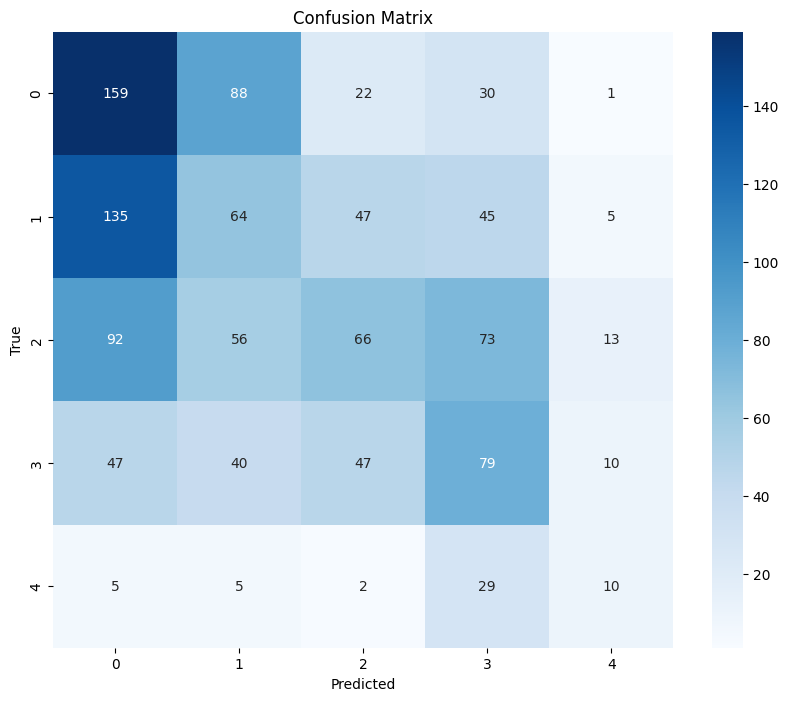

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 0 : 639
# 1 : 296
# 2 : 447
# 3 : 223
# 4 : 51

In [ ]:
# # Define the number of output classes
# num_classes = 5

# # Load pre-trained models and modify the final layer for transfer learning
# def get_pretrained_model(model_name, num_classes):
#     if model_name == 'resnet':
#         model = models.resnet18(pretrained=True)
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif model_name == 'densenet':
#         model = models.densenet121(pretrained=True)
#         model.classifier = nn.Linear(model.classifier.in_features, num_classes)
#     elif model_name == 'vgg':
#         model = models.vgg16(pretrained=True)
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
#     else:
#         raise ValueError('Unknown model name')
    
#     return model

# # 사전학습 모델 설정
# model_name = 'resnet'  # or 'densenet' or 'vgg'
# model = get_pretrained_model(model_name, num_classes)
# model = model.to(device)

# # Freeze initial layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# if model_name == 'resnet':
#     for param in model.fc.parameters():
#         param.requires_grad = True
# elif model_name == 'densenet':
#     for param in model.classifier.parameters():
#         param.requires_grad = True
# elif model_name == 'vgg':
#     for param in model.classifier[6].parameters():
#         param.requires_grad = True

# # Redefine optimizer to update only the last layer
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# # Training loop (same as before)
# num_epochs = 30
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         inputs = inputs.unsqueeze(1)  # Add channel dimension for grayscale images
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 100 == 99:
#             print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
#             running_loss = 0.0

#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in val_loader:
#             images, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             images = images.unsqueeze(1)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     print(f'Epoch {epoch + 1}, Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

# print('Training complete')

# # Testing phase (same as before)
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')


In [ ]:
# # 테스트 단계
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')